In [1]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model, load_model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

%matplotlib inline
import nltk
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


In [2]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [4]:
#TODO1 : remove url links. remove stop words. 
#save the tidy_tweet part into a text file to verify the validity.

df_train = pd.read_csv('data\\training\\2018-E-c-En-train.txt', sep="\t")
df_train['tidy_Tweet'] = np.vectorize(remove_pattern)(df_train['Tweet'], "@[\w]*") 
#df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z#]", " ")
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z]", " ")
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()
df_train['tidy_Tweet'] = df_train['tidy_Tweet'].apply(lambda x: ' '.join([lmtzr.lemmatize(w,'v') for w in x.split()]))
#df_train['tidy_Tweet'][:10].to_csv('tidy_Tweet.csv')
print(df_train.shape)
df_train['tidy_Tweet'][:10]

(6838, 14)


0    worry payment problem may never joyce meyer mo...
1                 whatever decide make sure make happy
2    also help majority nfl coach inept some bill b...
3    accept challenge literally even feel exhilarat...
4    roommate okay spell autocorrect terrible first...
5        cute atsu probably shy photos cherry help uwu
6             think humans sense recognize impend doom
7    rooneys fuck untouchable be fuck dreadful depa...
8         pretty depress hit pan favourite highlighter
9    pussy weak hear stfu bitch you get threaten pr...
Name: tidy_Tweet, dtype: object

In [6]:
#TODO1 : remove url links. remove stop words. 
#save the tidy_tweet part into a text file to verify the validity.

df_dev = pd.read_csv('data\\training\\2018-E-c-En-dev.txt', sep="\t")
df_dev['tidy_Tweet'] = np.vectorize(remove_pattern)(df_dev['Tweet'], "@[\w]*") 
#df_train['tidy_Tweet'] = df_train['tidy_Tweet'].str.replace("[^a-zA-Z#]", " ")
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].str.replace("[^a-zA-Z]", " ")
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words]))
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()
df_dev['tidy_Tweet'] = df_dev['tidy_Tweet'].apply(lambda x: ' '.join([lmtzr.lemmatize(w,'v') for w in x.split()]))
print(df_dev.shape)
df_dev['tidy_Tweet'][:10]

(886, 14)


0            hide revenge anger rememberthe time rebut
1                                  make sure smile bro
2    teamchristine tana do provoke tweet shady shit...
3    great start beginners jump auto trade profitab...
4            best friends drive first time car terrify
5    hey field skibbereen give online delivery serv...
6    why emmerdale rob robron first child together ...
7    would like hear podcast go refute entire artic...
8    hear one time intimidate men go explode why gu...
9                                      depression suck
Name: tidy_Tweet, dtype: object

In [7]:
#TODO0:
#still use 2018-E-c-En-train.txt as training data, but split it to X_train+X_val to be use dfor model_fit() 
#use 2018-E-c-En-dev.txt  as Test data (new X_test, y_test)  (887 lines)
#X_train, X_test, y_train, y_test = train_test_split(df_train.tidy_Tweet, df_train.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1), test_size=0.20, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(df_train.tidy_Tweet, df_train.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1), test_size=0.20, random_state=42)
X_train = df_train.tidy_Tweet
y_train = df_train.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1)
X_dev = df_dev.tidy_Tweet
y_dev = df_dev.drop(labels = ['ID','Tweet','tidy_Tweet'], axis=1)
                    

print(X_train.shape, X_dev.shape)
X_train_dev = pd.concat([X_train, X_dev])
#print(type(X_train), type(X_dev))
print(X_train_dev.shape)
#print(newX[:10])


(6838,) (886,)
(7724,)


In [8]:
#TODO 4: num_words: 10000 --> 
tokenizer = Tokenizer(num_words=10000)
#fix
#tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)
 
tokenizer.fit_on_texts(X_train_dev)
 
X_train = tokenizer.texts_to_sequences(X_train)
X_dev = tokenizer.texts_to_sequences(X_dev) #887 line

vocab_size = len(tokenizer.word_index) + 1

maxlen = 150
embed_size = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)
print("vocab_size:", vocab_size)

vocab_size: 11232


In [9]:
model = load_model('LSTM_model_ver1.h5')

In [10]:
def accuracy (y_dev, predictions, size):
    #a=predictions.toarray()
    a=predictions
    b=y_dev.to_numpy()
    U = np.zeros((size,11), dtype = np.int64)
    I = np.zeros((size,11), dtype = np.int64)
    sum=0
    for i in range(0,size):
        for j in range(0,10):
            if a[i][j]==1 or b[i][j]==1:
                U[i][j]=1
    for i in range(0,size):
        for j in range(0,10):
            if a[i][j]==1 and b[i][j]==1:
                I[i][j]=1
    for i in range(0,size):
        if U[i].tolist().count(1) == 0:
            sum = sum + 1
        else:
            sum = sum + I[i].tolist().count(1)/U[i].tolist().count(1)
    return sum/size

(886, 11)
<class 'numpy.ndarray'>


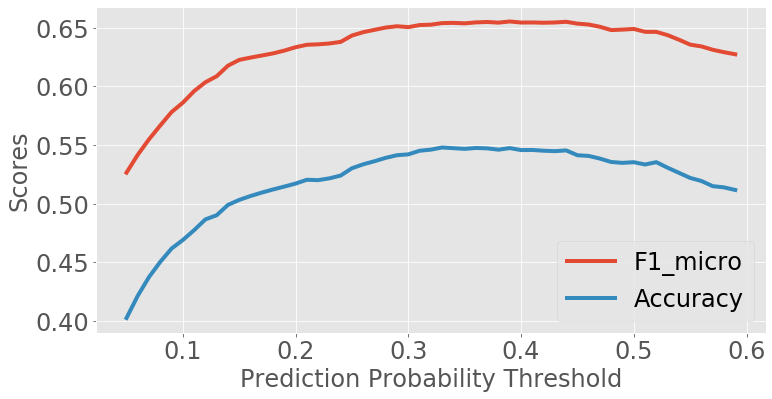

In [13]:
from sklearn.metrics import hamming_loss
#cc_classifier = ClassifierChain(SVC(kernel='linear', probability=True))
#cc_classifier.fit(x_train, y_train)
#cc_predictions_proba = cc_classifier.predict_proba(x_dev)

predictions=model.predict(X_dev)
print(predictions.shape)
print(type(predictions))
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
imp = []
for t in range (5,60): # threshold value
    y_pred_new = (predictions >= t/100).astype(int)
    #print("t =" ,t/100)
    #print("Accuracy = ",accuracy_score(y_dev,y_pred_new))
    #print("F1 = ",f1_score(y_dev,y_pred_new, average="micro"))
    #print("Hamming loss = ",hamming_loss(y_dev,y_pred_new))
    #print("imp = ",accuracy(y_dev,y_pred_new, X_dev.shape[0]))
    th.append(t/100)
    #ac.append(accuracy_score(y_dev,y_pred_new))
    f.append(f1_score(y_dev,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_dev,y_pred_new))
    imp.append(accuracy(y_dev,y_pred_new, X_dev.shape[0]))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f, linewidth = 4)
    plt.plot(th, imp, linewidth = 4)
    #plt.plot(th, ham, linewidth = 4)
    #plt.plot(th, ac, linewidth = 4)
    plt.legend(['F1_micro', 'Accuracy', 'Hamming loss'], loc='lower right', fontsize = 24)
    plt.xticks(fontsize = 24)
    plt.yticks(fontsize = 24)
    plt.ylabel("Scores", fontsize = 24)
    plt.xlabel("Prediction Probability Threshold", fontsize = 24)
    #plt.title("Performance Tuning", fontsize = 24)
plt.show()
